<h3 style="text-align: center;"><strong>ESCUELA DE INGENIERÍA INFORMÁTICA - UNIVERSIDAD DE SEVILLA</strong></h3>
<h3 style="text-align: center;"><strong>GRADO EN INGENIERÍA INFORMÁTICA</strong></h3>
<h1 style="font-size: 1em; text-align: center;"><strong>MATEMÁTICA DISCRETA<br /></strong></h1>
<h2 style="font-size: 1.17em; text-align: center;"><strong>Práctica 6. Estrategias ganadoras en juegos de estrategia a tiempo real.<br /></strong></h2>
<p>En este documento práctico tomaremos como referencia el juego de estrategia <strong>Stellaris</strong>, de la empresa Paradox Interactive, con el fin de emplear el estudio de grafos en esta categoría de juegos para ejecutar posibles estrategias que nos ofrezca ventajas o incluso nos garantice la victoria.</p>
<p>Esta práctica la dividiremos en los siguientes apartados:</p>
<p> 1. <a href= "#Grafo">Representación del mapa</a>.</p>
<p> 2. <a href= "#Exploracion">¿Cómo saber si se tiene un buen comienzo y cómo ejecutar la exploración?</a></p>
<p> 3. <a href= "#Ubicacion">Ubicaciones de la capital</a>.</p>
<p> 4. <a href= "#Comercio">Estudio del comercio</a>.</p>
<p> 5. <a href= "#Conquista">Conquista eficiente</a>.</p>
<p> 6. <a href= "#Defensa">Defensa del imperio</a>.</p>
<p> </p>
<p>Al final de la práctica hay una  <a href="#cuestiones">colección de otros ejercicios propuestos.</a></p>
<p> </p>
<p>Antes de empezar con la práctica, hagamos una pequeña introducción a Stellaris para así poder entender en qué consiste el videojuego y tener contexto para poder tener una mejor toma de decisiones a la hora de plantear una estrategia:</p>
<p><strong>Stellaris</strong> es un juego de gran estrategia en tiempo real ambientado en el espacio, cuyos combates se centran más en su preparación y estrategia que en el propio combate. También hay opciones diplomáticas, tales como alianzas y acuerdos comerciales con otras razas. El jugador comienza con un solo sistema en su poder. Cualquier partida empieza con la exploración y la colonización del espacio, para más avanzada la partida sus actividades se centren en la diplomacia y el cómo gobernar un imperio.</p>
<p>En este caso, nos centraremos en el aspecto de la exploración y la conquista de sistemas.</p>

<p> - <strong>IMPORTANTE:</strong></p>
<p>Antes de empezar con la práctica, es de suma importancia el hecho de importar las siguientes librerias que iremos usando a medida de que avancemos en la misma, para la ejecución de las funciones:</p>

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

Una vez importados los paquetes, podemos empezar con la ~~conquista~~ práctica.

---
<h2><a name= "Grafo"></a><strong>1. Representacion del mapa</strong></h2>
<p>Como se ha mencionado antes, al comenzar una partida tendremos en nuestro poder un sistema seleccionado de manera aleatoria y tendremos que explorar (y a su vez conquistar) los sistemas <strong>adyacentes</strong> al nuestro para así ir expandiendo nuestro territorio.</p>
<p>El problema que tenemos es que no sabemos de forma gráfica cómo es la galaxia en la que nos encontramos, o dicho de la mejor forma, no sabemos cómo es el <strong>mapa</strong> de la partida, ya que éste varía completamente cuando empezamos otras partidas.</p>
<p>Para solucionar este problema haremos una <strong>representación gráfica</strong> del mapa de nuestra partida.</p>
<p>La función <em>lectura()</em> nos representará el mapa de nuestra partida como un diccionario. Cada partida estará nombrada como <em>"gamestate_.json"</em>, donde '_' es un <strong>número del 0 al 9</strong>. Aunque para eso primero tendremos que leer el mapa.</p>

In [15]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [16]:
partida = lectura('./output/output0.json')

<p>Una vez leído el mapa podremos ahora sí representarlo:</p>

In [17]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [18]:
print('Total de sistemas que hay en el mapa:', len(partida))
test_lectura(partida)

Total de sistemas que hay en el mapa: 394
Mostrando los tres primeros sistemas de la galaxia:
0 :  ['Bashpat', [(92, 16), (249, 14), (99, 14)], (90.86, 28.64)]
1 :  ['NAME_Trappist', [(146, 23), (62, 20), (326, 20), (43, 19), (154, 12)], (-70.84, -10.85)]
2 :  ['Jishui', [(4, 29), (355, 25), (266, 24), (248, 22), (299, 21), (174, 18)], (107.14, 133.98)]
...
Mostrando los tres últimos sistemas de la galaxia:
391 :  ['Bastamore', [(302, 18), (170, 30)], (-101.26, -245.93)]
392 :  ['Ijax', [(78, 25), (97, 19), (163, 29)], (22.03, 182.22)]
393 :  ['Witzen', [(193, 16.25289)], (132.4183, 279.02054)]


<p>Podemos observar que las <strong>claves</strong> del diccionario son los sistemas (vértices) de la partida y sus <strong>valores</strong> es representado como una lista en la que podemos ver que está constituída por el nombre de dicho sistema, una lista de tuplas con los sistemas conectados y sus pesos, y una tupla coordenada del sistema.</p>
<br></br>
<p>Una vez que tenemos el diccionario, empezaremos a representar nuestro mapa poco a poco. Comenzaremos por lo más básico de nuestro mapa: los sistemas y sus conexiones presentes.</p>
<p>La siguiente función <em>genera_grafo()</em> nos generará una representación en forma de grafo del mapa de nuestra partida, aunque primero lo iremos representando como diccionarios, para que observemos detenidamente cómo son distribuidos cada uno de los valores en los que se trabaja (aun así es importante la ejecución de cada una de las funciones por orden).</p>
<p style="font-size: 0.87em">Iremos haciendo esto con cada uno de los procesos hasta que dibujemos ya el mapa completo :)</p>

In [19]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    return grafo

In [20]:
mapa = genera_grafo(partida)

<p>Como se ha visto con la función <em>lectura()</em>, se le ha atribuido a cada función una función test para que nos devuelva su diccionario:</p>

In [21]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [22]:
test_genera_grafo(partida)

Mostrando las conexiones de los tres primeros sistemas de la galaxia:
0 : [92, 249, 99]
1 : [146, 62, 326, 43, 154]
2 : [4, 355, 266, 248, 299, 174]
...
Mostrando las conexiones de los tres últimos sistemas:
391 : [170, 302]
392 : [78, 97, 163]
393 : [193]


<p>Podemos observar que a cada clave del diccionario, que es el sistema de la galaxia, se le atribuye a una lista de enteros. Dicha lista representa los <strong>sistemas</strong> a los que la clave está conectada en el mapa.</p>
<br></br>
<p>Una vez que tenemos la representación simple del mapa por sus conexiones, ahora le iremos atribuyendo a cada conexión de dos sistemas su <strong>distancia</strong> entre ellos. Para eso usaremos la función <em>adjudica_pesos()</em> para determinar cada uno de los <strong>pesos</strong> correspondientes a cada arista:</p>

In [23]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [24]:
pesos_mapa = adjudica_pesos(mapa, partida)

<p> - Test de <em>adjudica_pesos()</em>:</p>

In [25]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [26]:
test_adjudica_pesos(mapa, partida)

Distancias entre los primeros tres sistemas y sus conexiones:
0 : [(92, 16), (249, 14), (99, 14)]
1 : [(146, 23), (62, 20), (326, 20), (43, 19), (154, 12)]
2 : [(4, 29), (355, 25), (266, 24), (248, 22), (299, 21), (174, 18)]
...
Distancias entre los tres últimos sistemas y sus conexiones:
391 : [(302, 18), (170, 30)]
392 : [(78, 25), (163, 29), (97, 19)]
393 : [(193, 16.25289)]


<p>En este caso podemos ver que la función <em>adjudica_pesos()</em> nos devuelve otro grafo representado como un diccionario. Dicho diccionario tendrá los sistemas como claves y sus valores serán una lista de tuplas constituidas por el sistema conectado y su <strong>distancia</strong> con respecto al sistema.</p>
<br></br>
<p>Ahora debemos considerar las posiciones de los sistemas de nuestra galaxia. Obviamente no sabemos con exactitud la ubicación de cada uno de ellos. Recuerda que saber las ubicaciones del territorio que queremos conquistar es una de las <strong>piezas estratégicas clave</strong> para poder expendir con facilidad nuestro imperio.</p>
<p>Dependeremos de la función <em>adjudica_posiciones</em> para saber las localizaciones exactas de los sistemas presentes en el mapa:</p>

In [27]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [28]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

<p> - Test de <em>adjudica_posiciones()</em>:</p>

In [29]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [30]:
test_adjudica_posiciones(mapa, partida)

Coordenadas de los tres primeros sistemas:
0 : (90.86, 28.64)
1 : (-70.84, -10.85)
2 : (107.14, 133.98)
...
Coordenadas de los tres últimos sistemas:
391 : (-101.26, -245.93)
392 : (22.03, 182.22)
393 : (132.4183, 279.02054)


<p>En este caso, el diccionario del grafo que nos devuelve la función <em>adjudica_posiciones</em> será uno cuyas claves siguen siendo los sistemas y sus valores son la tupla <em>Coordenada</em> del sistema, con valores <strong>x</strong> e <strong>y</strong>.</p>
<br></br>
<p>Una vez que tenemos el mapa con los sistemas colocados en sus posiciones correspondientes seguido de las distancias de las conexiones entre éstos, sólo nos queda un detalle que agregar al mapa. Este detalle es el más importante aunque no lo parezca. Dicho detalle se puede responder con la siguiente pregunta de una manera muy sencilla:</p>
<p style="text-align: center;"><strong>¿Cómo sabemos cuál <u>sistema</u> es el que se encuentra en x sistema?</strong></p>
<p>Como dice la pregunta, un mapa sin que los territorios estén marcados con los nombres de dichos territorios es un mapa incompleto. Para solucionar esto se tiene la función <em>adjudica_etiqueta()</em>, que nos nombrará a cada sistema por su nombre registrado.</p>

In [31]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [32]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

<p> - Test de <em>adjudica_etiquetas()</em>:</p>

In [33]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

In [34]:
test_adjudica_etiquetas(mapa, partida)

Etiquetas correspondientes a los tres primeros sistemas:
0 : Bashpat
1 : NAME_Trappist
2 : Jishui
...
Etiquetas correspondientes a los tres últimos sistemas:
391 : Bastamore
392 : Ijax
393 : Witzen


<p>Podemos observar que el diccionario que nos devuelve atribuye a cada sistema el nombre de éste.</p>
<br></br>
<p>Con esto ya tenemos todos los elementos necesarios para poder representar nuestro mapa de forma completa.</p>
<br><strong>¡Por fin podremos ver cómo es la galaxia en la que nos encontramos!</strong></br>
<p></p>
<p>Para poder dibujar nuestro mapa simplemente tenemos que hacer dos cosas previas:</p>
<p><em>1-. Variable posiciones para marcar las coordenadas de cada sistema.</em></p>
<p><em>2-. <u>plt.figure(figsize=(a, b))</u> para ajustar el tamaño del mapa.</em></p>

<p><strong>CUIDADO (antes de que continúes):</strong></p>
<p><strong>Debido a que hemos implementado las librerias <u>nx</u>, las funciones que se dan para representar grafos en las anteriores prácticas no van a funcionar. Para representar los grafos utilizaremos la función <u>nx.draw()</u>.</strong></p>

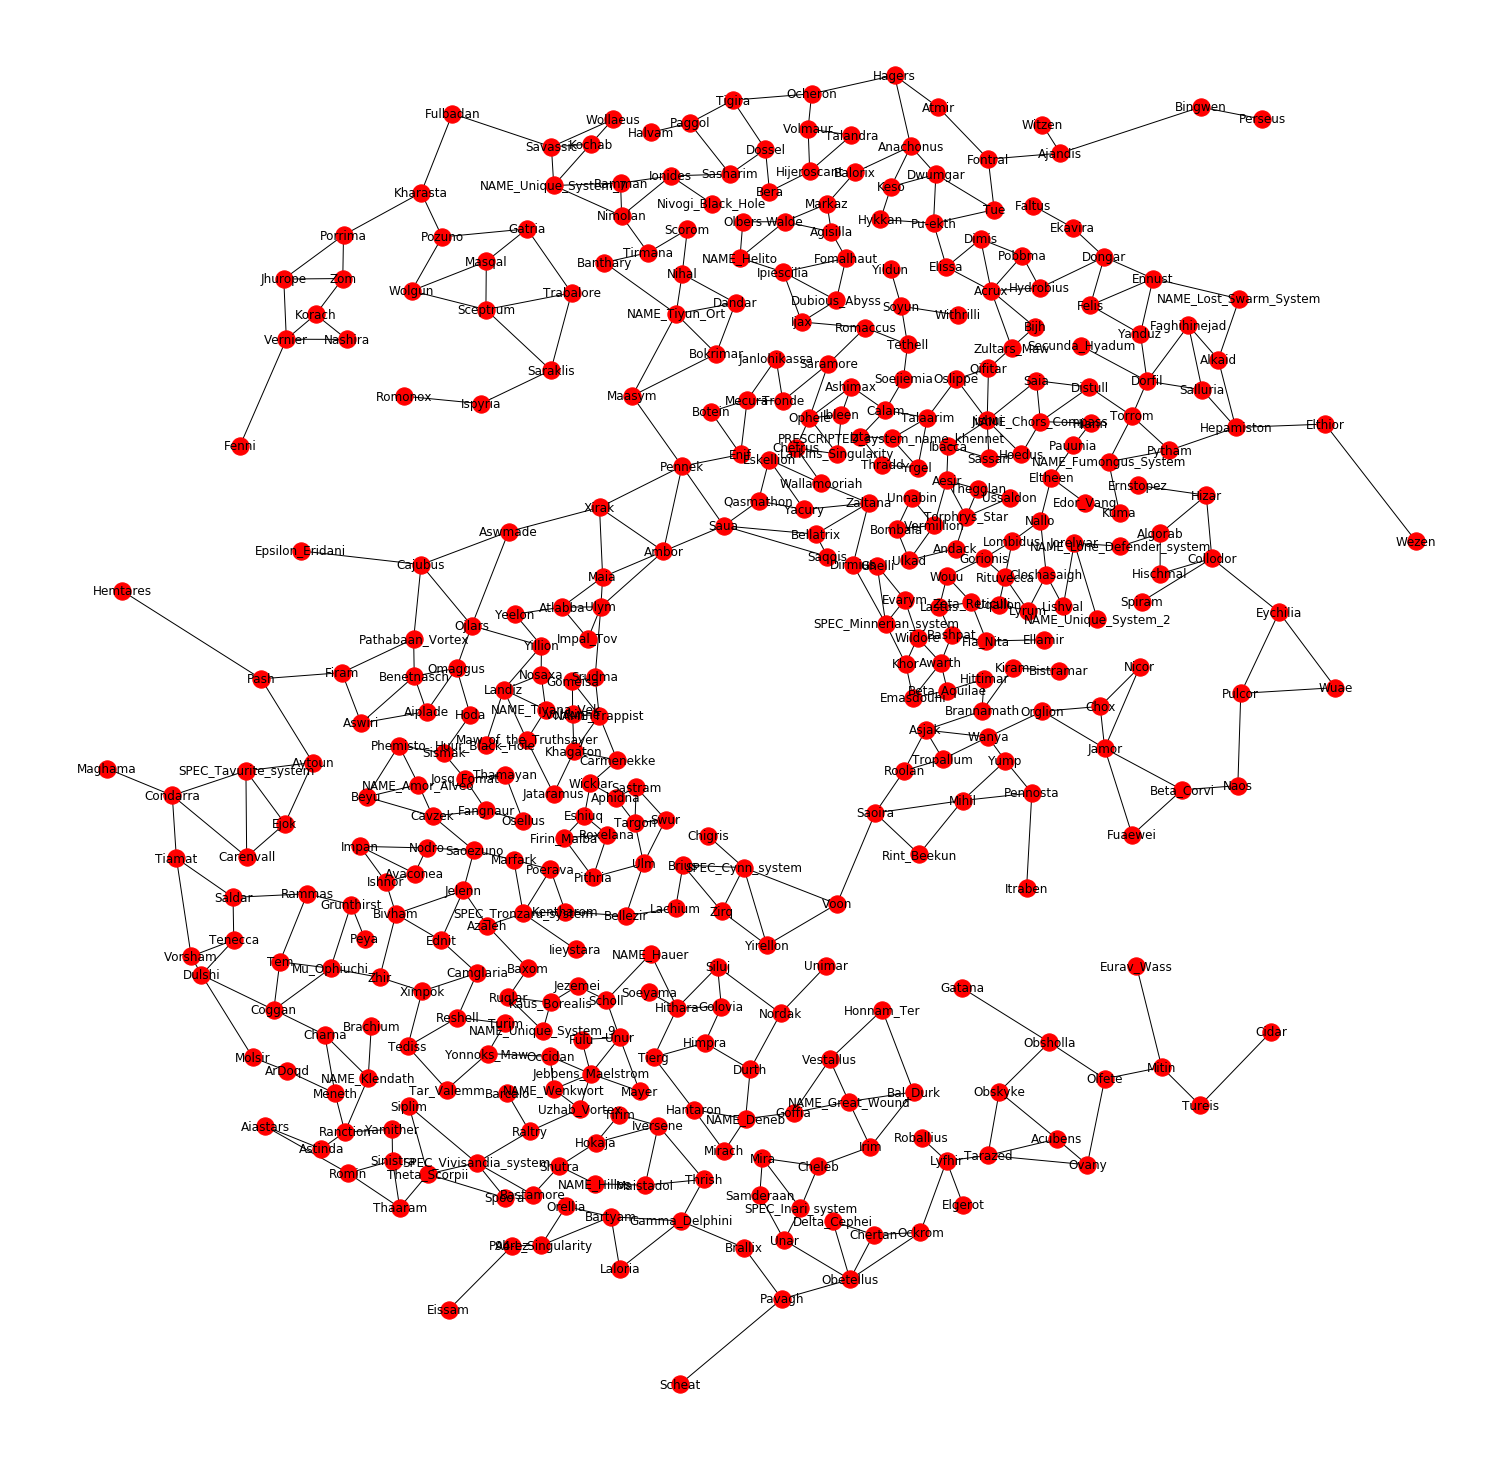

In [35]:
posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
plt.figure(figsize=(20, 20))
nx.draw(mapa_completo, pos=posiciones, labels=nx.get_node_attributes(mapa_completo, "Label"), font_size=12)

<p>La representación gráfica de arriba es una representación simple del mapa sin tener en cuenta las distancias de los sistemas.</p>
<p></p>
</p>Para poder diferenciar los pesos con mejor visualización, haremos que cuanto mayor dea la conexión entre dos sistemas, mayor será su distancia:</p>

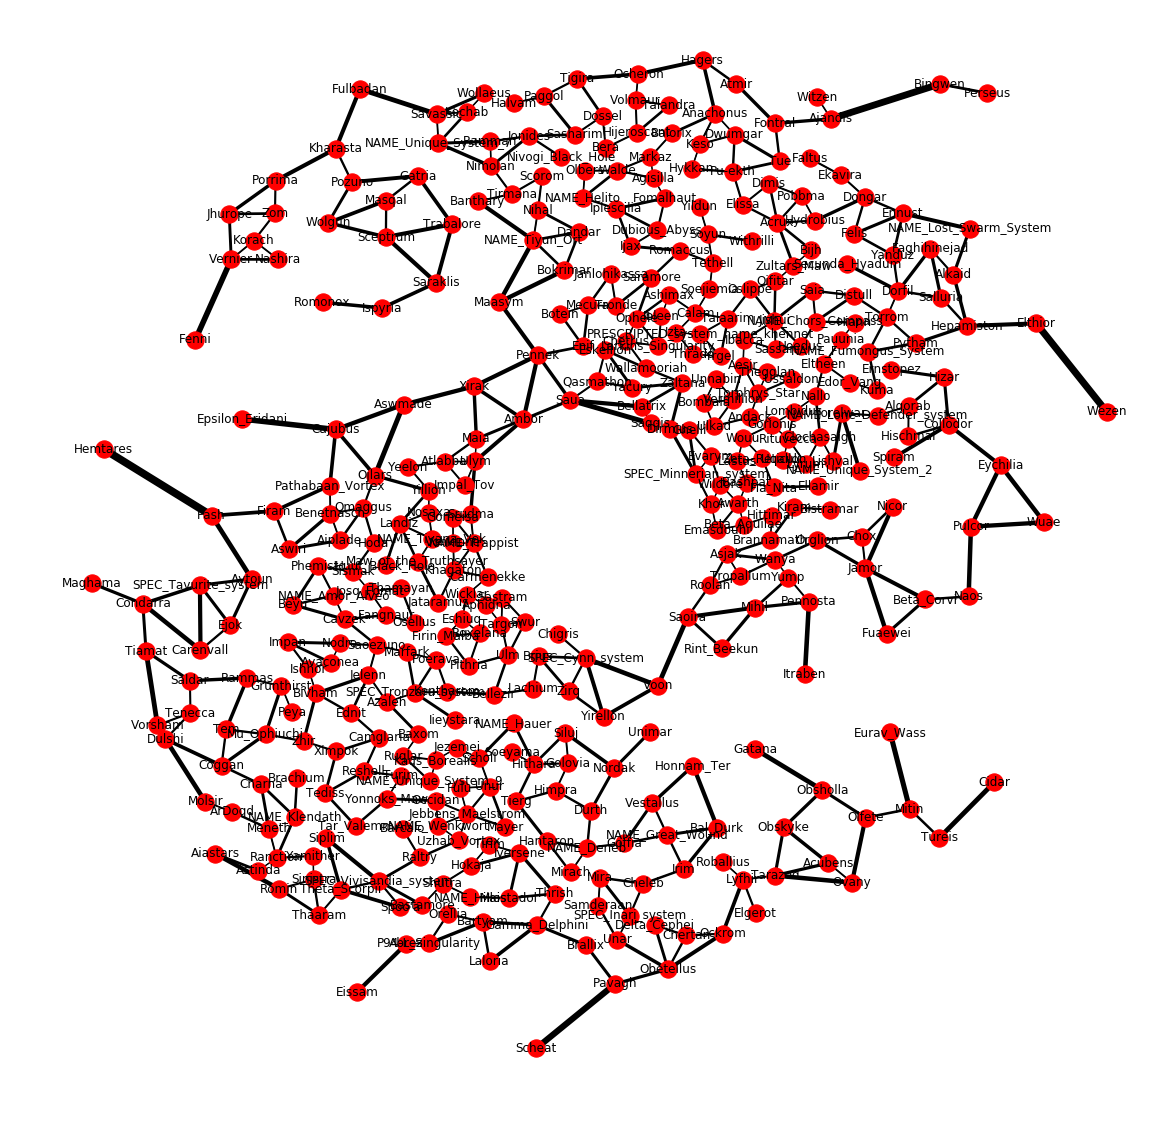

In [36]:
posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
plt.figure(figsize=(20, 20))
edge_widths = [mapa_completo[u][v]['weight']/10 for u, v in mapa_completo.edges]
nx.draw_networkx_edges(mapa_completo, pos=posiciones, width=edge_widths)
nx.draw(mapa_completo, pos=posiciones, labels=nx.get_node_attributes(mapa_completo, "Label"), font_size=12)

<p>3) Mapa por países</p>

<p>Con todo esto, podemos plantear ya nuestras estrategias para nuestra futura expansión territorial.</p>

---
<h2><a name="Exploracion"></a><strong>2. ¿Cómo saber si se tiene un buen comienzo y cómo ejecutar la exploración?</strong></h2>
<p>Sabiendo ya la forma que tiene nuestra galaxia y cómo funciona, podremos ubicarnos en ésta y plantear ya nuestra estrategia para comenzar con nuestra expansión por el espacio.</p>
<p>Sólo hay una variable que hace que a la hora de tomar ciertas decisiones hagamos una cosa u otra. Así es, hablamos del <strong>comienzo</strong>.</p>
<p>Que hayamos empezado de <em>x</em> manera en la galaxia repercute en nuestra manera de explorar y reunir información suficiente para conquistar o no ciertos sistemas y así extender nuestros dominios de la <strong>manera más eficiente</strong>. Una mala decisión puede acabar en una posible caída de nuestro imperio por posición estratégica.</p>
<p></p>
<p>Para empezar debemos ver qué sistemas de la galaxia nos permite aislar otros sistemas si son tomadas. Para ello la función <em>puntos_de-corte_y_aislamiento()</em> nos dirá cuáles son esos sistemas que aislan otros sistemas si son conquistadas y cuáles son aquellos sistemas que se aislan:</p>

In [37]:
def puntos_de_corte_y_aislamiento(grafo: nx.Graph):
    dicc = dict()
    for i in list(nx.articulation_points(grafo)):
        grafoaux = grafo.copy()
        grafoaux.remove_node(i)
        dicc[i] = sorted(nx.connected_components(grafoaux), key=len, reverse=True)[1:]
    for i in dicc:
        dicc[i] = [elemento for sublista in dicc[i] for elemento in sublista]
    return dicc

<p>- Test de <em>puntos_de_corte_y_aislamiento()</em>:</p>

In [38]:
puntos_corte_g = puntos_de_corte_y_aislamiento(mapa_completo)
print('Mostrando los tres primeros sistemas de corte:')
for r in sorted(puntos_corte_g)[:3]:
    print(str(r) +  ":" + ((3-len(str(r)))*" ") +str(puntos_corte_g[r]))
print("...")
print('Mostrando los tres últimos sistemas de corte:')
for r in sorted(puntos_corte_g)[-3:]:
    print(str(r) +  ":" + ((3-len(str(r)))*" ") +str(puntos_corte_g[r]))

13: [64, 101, 38, 71, 329, 338, 59, 124]
17: [285]
21: [291, 317]
...
379:[234]
384:[385, 98, 312, 328, 296, 250, 335, 211, 372, 120, 186, 219, 290]
387:[360, 110, 17, 374, 89, 285]


<p>Teniendo ya los sistemas de corte disponibles, sólo necesitaremos aquellos que sean <strong>maximales</strong>, es decir, aquellos puntos de corte que no pueden ser separados del grafo principal mediante otro punto de corte con el fin de evitar la saturación del mapa de puntos de cortes rebundantes.</p>

In [39]:
def elimina_redundancias(dicc: dict):
    diccaux = dicc.copy()
    conjunto_aislante={r[0] for r in diccaux.items()}
    conjunto_aislado={j for i in diccaux.items() for j in i[1]}
    for r in dicc:
        if r not in conjunto_aislante.difference(conjunto_aislado):
            diccaux.pop(r)
    return diccaux

<p>- Test de <em>elimina_rebundancias()</em>:</p>

In [40]:
puntos_corte_maximales_g = elimina_redundancias(puntos_corte_g)
print('Mostrando los tres primeros sistemas de corte maximales:')
for r in sorted(puntos_corte_maximales_g)[:3]:
    print(str(r) + ": " + ((3-len(str(r)))*" ") + str(puntos_corte_maximales_g[r]))
print("...")
print('Mostrando los tres últimos sistemas de corte maximales:')
for r in sorted(puntos_corte_maximales_g)[-3:]:
    print(str(r) + ": " + ((3-len(str(r)))*" ") + str(puntos_corte_maximales_g[r]))

21:  [291, 317]
45:  [201, 382]
46:  [240]
...
299: [64, 101, 38, 71, 329, 13, 338, 59, 124]
330: [84]
379: [234]


<p>Una vez que tengamos los sistemas de corte maximales determinados, debemos de saber cuál es la distancia a la que debemos aspirar recorrer a lo largo de la galaxia en base al número de países que se encuentran en la galaxia.</p>
<p>Gracias a la función <em>topedist()</em> podremos saber cuál es esa <strong>distancia máxima</strong> que debemos alcanzar a la hora de iniciar nuestra conquista.</p>
<p>Una cosa a tener en consideración es que el parámetro <em>numParticipantes</em> se refiere al número de países que se encuentran en la galaxia. Esto es importante debido a que <em>Stellaris</em> es un juego de estrategia multijugador a tiempo real, es decir, que ciertos sistemas pueden ser controlados por dichos paises, paises que tratarán de evitar a toda costa la toma de dicho sistema si es importante.</p>

In [41]:
def topedist(grafo: nx.Graph, numParticipantes: int):
    lis = [w[2]["weight"] for w in grafo.edges(data=True)]
    avglongitud = sum(lis)/len(lis)
    pesototal = sum([w[2]["weight"] for w in grafo.edges(data=True)])
    pesoporpart = 1.2*pesototal/numParticipantes
    saltos = math.log(pesoporpart, ((grafo.number_of_edges()*2)/grafo.number_of_nodes()-1))
    return saltos*avglongitud

In [42]:
print("La distancia máxima a la que deberíamos aspirar es:",topedist(mapa_completo, 10))

La distancia máxima a la que deberíamos aspirar es: 296.45968657864256


<p>Ahora que hemos determinado la distancia máxima a la que es sensato aspirar, podemos determinar que tan bueno es nuestro origen segun la distancia a los puntos de corte maximales:</p>

In [43]:
def rankea(grafo: nx.Graph, dicc_corte: dict, numpart: int):
    ranking = dict()
    toped = topedist(grafo, numpart)
    for i in grafo.nodes():
        punt=0
        for j in dicc_corte:
            dist = nx.shortest_path_length(grafo, i, j, weight="weight")
            if dist<toped:
                punt+=(len(dicc_corte[j])*(toped-dist)/toped)
        ranking[i] = punt
    return ranking

<p>- Test de <em>rankea()</em>:</p>

In [44]:
ranking = rankea(mapa_completo, puntos_corte_maximales_g, 10)
maximo = max([ranking[an] for an in ranking])
rankingordenado = [(r[0], 10*r[1]/maximo) for r in sorted(ranking.items(),key=lambda a:a[1], reverse=True)]

In [45]:
print("Imprimiento los diez mejores sistemas")
for r in range(10):
    print(rankingordenado[r])

Imprimiento los diez mejores sistemas
(127, 10.0)
(166, 9.836582339887434)
(153, 9.337495972516622)
(200, 9.318356967278216)
(221, 9.284495650317954)
(35, 9.162977227937091)
(319, 8.966493717125935)
(192, 8.882576540311376)
(272, 8.829576218112706)
(208, 8.768537975142596)


In [46]:
print("Imprimiento los diez peores sistemas")
for r in range(10):
    print(rankingordenado[-(r+1)])

Imprimiento los diez peores sistemas
(175, 0.0)
(211, 0.38692395238596194)
(386, 0.685822323536018)
(256, 0.756216573902146)
(118, 0.8116387380822789)
(44, 0.8234165874597611)
(252, 0.8293055121485022)
(222, 0.8505935134696089)
(251, 0.862371362847091)
(154, 0.8769749732177842)


<p>Para mayor claridad representaremos el grafo, dandole color y tamaño a los nodos segun su puntuacion:</p>

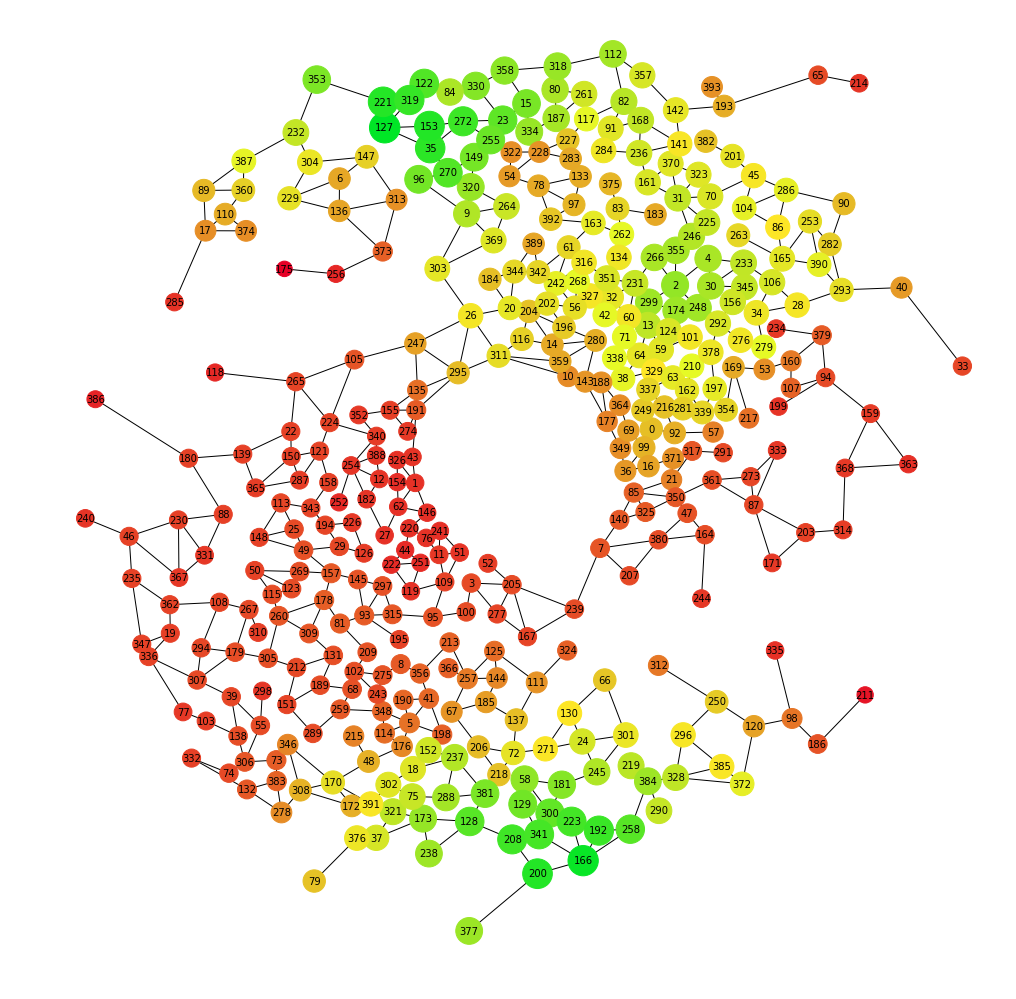

In [47]:
nodo_posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
nodo_colores = [
    (2 * (1 - (ranking[r] / maximo)), 0.9, 0.15) 
    if ranking[r]/maximo > 0.5 
    else (0.9, 2 * (ranking[r] / maximo), 0.15) for r in ranking]
nodo_tamano = [30*(8+r[1]) for r in ranking.items()]
plt.figure(figsize=(13.4,13.4))
nx.draw(mapa_completo,with_labels=True, pos=nodo_posiciones, font_size=10, node_color=nodo_colores, node_size=nodo_tamano)

<p><strong><em>¿Quieres mejorar el algoritmo?</em></strong></p>
<p>Prueba a hacer que tenga en cuenta conjuntos de corte que desconecten el grafo, deberás tener en cuenta cuantos puntos son necesarios para desconectar el grafo, asi como la distancia entre ellos, un posible comienzo sería:</p>

<em>
(Tamaño del sector aislado * (distancia maxima - ruta mas corta que atraviese el conjunto de corte)) /(tamaño del conjunto de corte * distancia maxima)
</em>

<p>Ahora que ya sabemos que tan bueno o malo es nuestro origen debemos determinar por donde ha de empezar nuestra <strong>expansión galactica</strong>, obtendremos en primer lugar las rutas a los puntos de interes:</p>

In [48]:
def destinos_posibles(grafo: nx.Graph, puntoinicio: int,participantes: int):
    grafoaux = grafo.copy()
    distancias, caminos = nx.single_source_dijkstra(grafoaux, puntoinicio)
    limite = topedist(grafo, participantes)
    destinos = puntos_de_corte_y_aislamiento(grafo)
    for r in distancias:
        if(distancias[r]>limite):
            grafoaux.remove_node(r)
        if (r not in destinos or distancias[r]>limite):
            caminos.pop(r)
    
    return grafoaux, caminos

In [49]:
origen = 130

In [50]:
subg, caminos = destinos_posibles(mapa_completo, origen, 10)

In [51]:
print("Todos los posibles puntos de interes para nuestro origen son: ", list(caminos.keys()))

Todos los posibles puntos de interes para nuestro origen son:  [111, 257, 166, 258, 200, 384, 128, 328, 173, 48]


<p>Representamos las rutas a esos caminos en el mapa:</p>

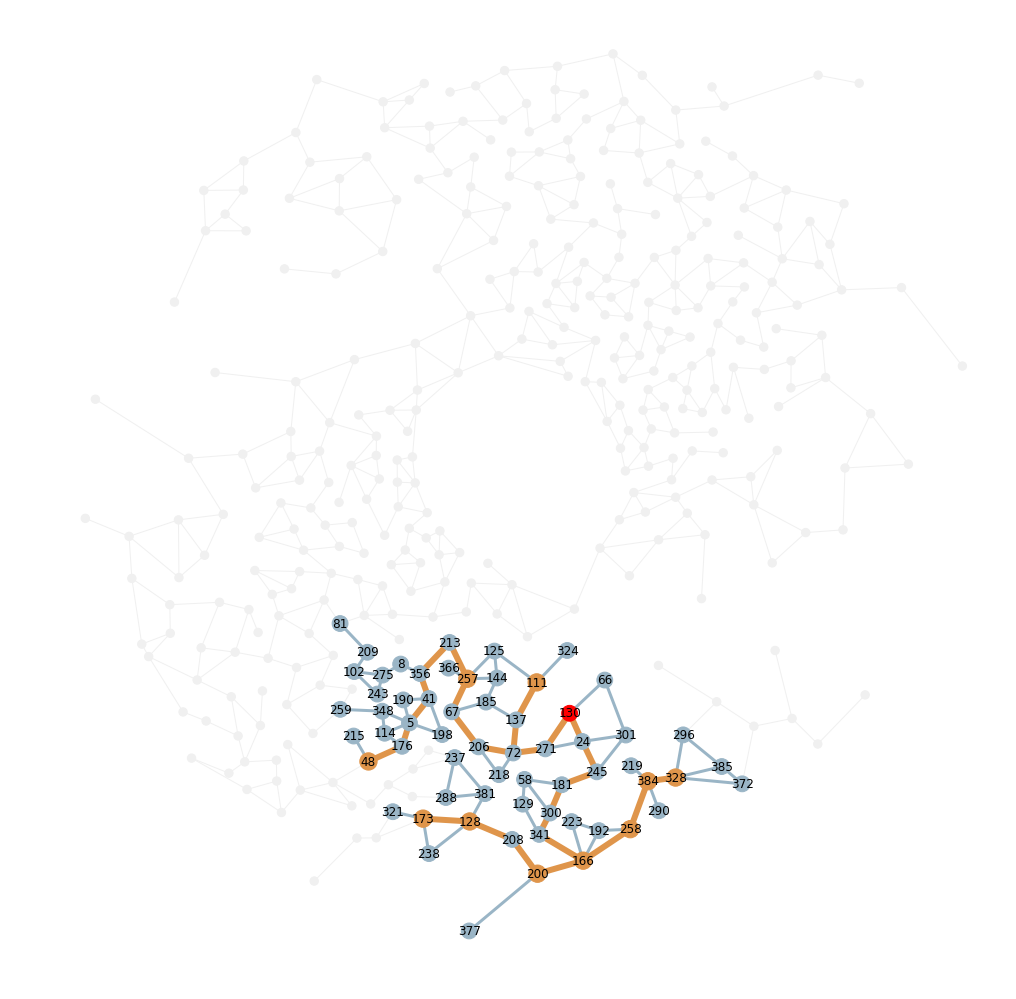

In [52]:
conjunto = set()
for r in caminos:
    if caminos[r][-1] in caminos:
        conjunto.update([(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in puntos_corte_g and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    300 if r in subg.nodes() and r in puntos_corte_g 
    else 250 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(
    mapa_completo, 
    node_size=nodo_tamano, 
    labels=nodo_etiquetas, 
    pos=nodo_posiciones, 
    node_color=nodo_colores, 
    edge_color=arista_colores, 
    width=arista_tamano
)

<p>Es tiempo ahora de determinar los puntos de máximo interés, pues como podemos ver en la representación hay puntos que no son relevantes en comparación a otros. Tenemos que saber también <strong>cómo expandirnos</strong> considerando que no es necesario ocupar todos los sistemas que hay presentes, con sólo los maximales de corte nos vale.</p>

In [53]:
def explora(grafo: nx.Graph, dicc_corte: dict, numpart: int, origen:int):
    toped = topedist(grafo, numpart)
    pesos, caminos = nx.single_source_dijkstra(grafo,origen)
    pesos = {r: pesos[r] for r in pesos if r in dicc_corte and r != origen}
    caminos = {r: caminos[r] for r in caminos if r in dicc_corte and r != origen}
    puntuacion_dict = dict()
    caminos_finales=dict()
    for i in pesos:
        if pesos[i]<toped:
            puntuacion_dict[i] = (len(dicc_corte[i])*(toped-pesos[i])/toped)
            caminos_finales[i]=caminos[i]
    for i in caminos:
        for j in caminos[i]:
            if i in puntuacion_dict and j in puntuacion_dict and puntuacion_dict[i]<puntuacion_dict[j] and i in dicc_corte[j]:
                puntuacion_dict.pop(i)
                caminos_finales.pop(i)
    return puntuacion_dict, caminos_finales

In [54]:
mejores_destinos, caminos_finales = explora(mapa_completo,puntos_corte_g , 10, origen)
print(f"El mejor destino es el {max(mejores_destinos.items(), key=lambda a:a[1])[0]}, con una puntuacion de {max(mejores_destinos.items(), key=lambda a:a[1])[1]}")

El mejor destino es el 166, con una puntuacion de 8.685210126044899


<p>Gracias a la función <em>explora()</em> hemos podido evaluar el destino

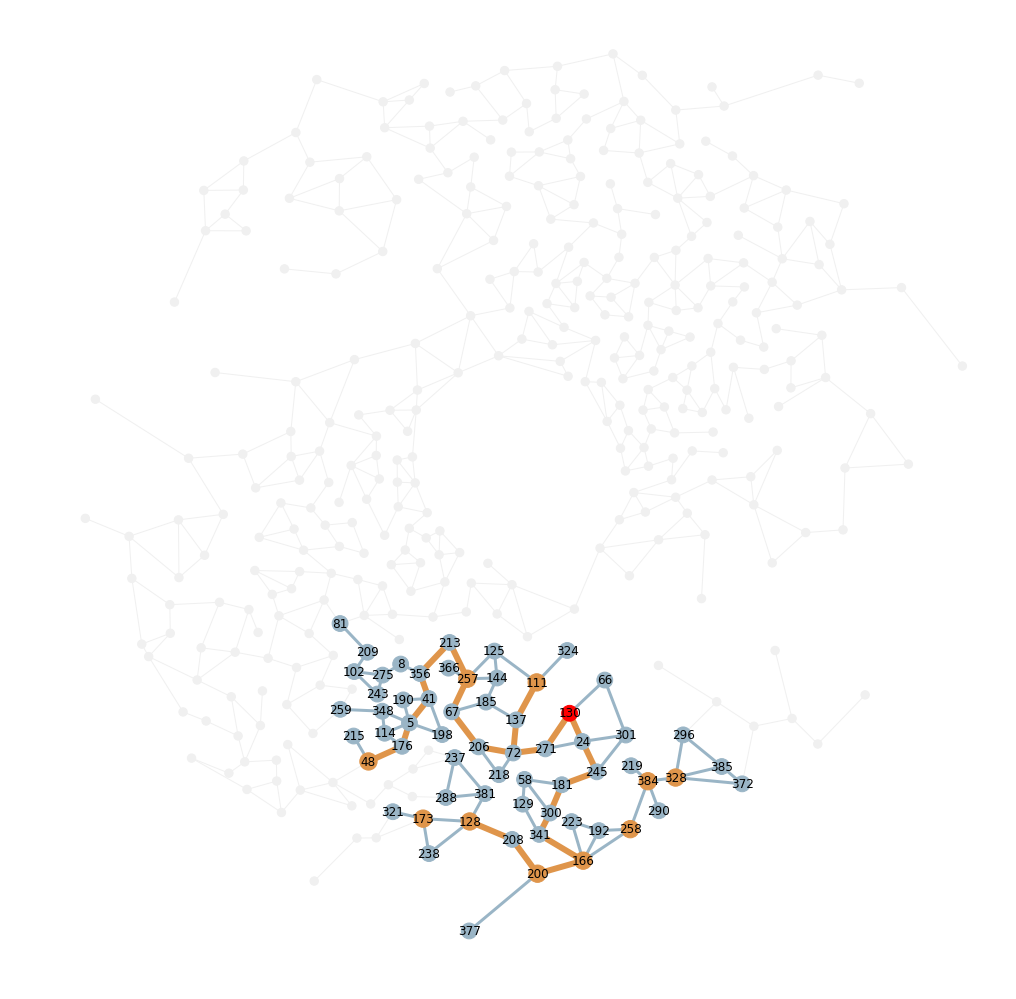

In [55]:
conjunto = set()
for r in caminos_finales:
    if caminos[r][-1] in caminos_finales:
        conjunto.update([(caminos_finales[r][k], caminos_finales[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in puntos_corte_g and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    300 if r in subg.nodes() and r in puntos_corte_g 
    else 250 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(
    mapa_completo, 
    node_size=nodo_tamano, 
    labels=nodo_etiquetas, 
    pos=nodo_posiciones, 
    node_color=nodo_colores, 
    edge_color=arista_colores, 
    width=arista_tamano
)

In [56]:
def mejores_rutas(grafo: nx.Graph, caminos: dict):
    diccaux=dict()
    for r in caminos:
        diccaux[r] = [(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)]
    return diccaux

In [57]:
rutas_finales_aristas = mejores_rutas(mapa_completo, caminos_finales)
print(rutas_finales_aristas)

{111: [(130, 271), (271, 72), (72, 137), (137, 111)], 257: [(130, 271), (271, 72), (72, 206), (206, 67), (67, 257)], 166: [(130, 24), (24, 245), (245, 181), (181, 300), (300, 341), (341, 166)], 200: [(130, 24), (24, 245), (245, 181), (181, 300), (300, 341), (341, 166), (166, 200)], 128: [(130, 24), (24, 245), (245, 181), (181, 300), (300, 341), (341, 166), (166, 200), (200, 208), (208, 128)], 48: [(130, 271), (271, 72), (72, 206), (206, 67), (67, 257), (257, 213), (213, 356), (356, 41), (41, 5), (5, 176), (176, 48)]}


In [58]:
def generar_combinaciones(lista):
    result = []

    for i in range(1, len(lista) + 1):
        combinaciones_i = get_combinaciones(lista, i)
        result.extend(combinaciones_i)

    return result

def get_combinaciones(lista, longitud):
    result = []
    combinacion_actual = [0] * longitud

    generar_combinaciones_util(lista, result, combinacion_actual, 0, len(lista) - 1, 0, longitud)

    return result

def generar_combinaciones_util(lista, result, combinacion_actual, inicio, fin, indice_actual, longitud):
    if indice_actual == longitud:
        result.append(combinacion_actual.copy())
        return

    i = inicio
    while i <= fin and fin - i + 1 >= longitud - indice_actual:
        combinacion_actual[indice_actual] = lista[i]
        generar_combinaciones_util(lista, result, combinacion_actual, i + 1, fin, indice_actual + 1, longitud)
        i += 1

In [59]:
resultados = generar_combinaciones(list(rutas_finales_aristas.keys()))
print(resultados)

[[111], [257], [166], [200], [128], [48], [111, 257], [111, 166], [111, 200], [111, 128], [111, 48], [257, 166], [257, 200], [257, 128], [257, 48], [166, 200], [166, 128], [166, 48], [200, 128], [200, 48], [128, 48], [111, 257, 166], [111, 257, 200], [111, 257, 128], [111, 257, 48], [111, 166, 200], [111, 166, 128], [111, 166, 48], [111, 200, 128], [111, 200, 48], [111, 128, 48], [257, 166, 200], [257, 166, 128], [257, 166, 48], [257, 200, 128], [257, 200, 48], [257, 128, 48], [166, 200, 128], [166, 200, 48], [166, 128, 48], [200, 128, 48], [111, 257, 166, 200], [111, 257, 166, 128], [111, 257, 166, 48], [111, 257, 200, 128], [111, 257, 200, 48], [111, 257, 128, 48], [111, 166, 200, 128], [111, 166, 200, 48], [111, 166, 128, 48], [111, 200, 128, 48], [257, 166, 200, 128], [257, 166, 200, 48], [257, 166, 128, 48], [257, 200, 128, 48], [166, 200, 128, 48], [111, 257, 166, 200, 128], [111, 257, 166, 200, 48], [111, 257, 166, 128, 48], [111, 257, 200, 128, 48], [111, 166, 200, 128, 48], [2

In [60]:
def peso_desde_ruta(grafo: nx.Graph, ruta: list):
    return sum([grafo.edges()[r]["weight"] for r in ruta])
peso_desde_ruta(mapa_completo,rutas_finales_aristas[111])

106

In [61]:
#Ahora vemos cuales rutas comparten la mayoria de sus elementos
def ruta_maximal(grafo: nx.Graph, lista_combinaciones: list,rutas: dict):
    dicc_pesos= dict()
    for i in lista_combinaciones:
        for j in i:
            dicc_pesos[j] = peso_desde_ruta(grafo, rutas[j])
    combinaciones_interesantes= dict()
    for i in lista_combinaciones:
        elemento_maximo, ruta_maxima, peso_maximo = max([ (r,rutas[r], peso_desde_ruta(grafo, rutas[r])) for r in i], key=lambda a:a[1])
        flag_es_almacenado=True
        for j in i:
            if j!=elemento_maximo:
                conjunto_caminos=set()
                conjunto_caminos.update(ruta_maxima)
                conjunto_caminos.update(rutas[j])
                if peso_desde_ruta(grafo, conjunto_caminos)-peso_maximo>(peso_desde_ruta(grafo,rutas[j])/2):
                    flag_es_almacenado=False
        if(flag_es_almacenado):
            conjunto_caminos=set()
            for j in i:
                conjunto_caminos.update(rutas[j])    
            combinaciones_interesantes[tuple(i)]=conjunto_caminos

    return(combinaciones_interesantes)

In [62]:
rutas_maximales=ruta_maximal(subg, resultados, rutas_finales_aristas)
for r in rutas_maximales:
    print(str(r) + ":",rutas_maximales[r])

(111,): {(130, 271), (72, 137), (271, 72), (137, 111)}
(257,): {(72, 206), (67, 257), (206, 67), (271, 72), (130, 271)}
(166,): {(300, 341), (245, 181), (341, 166), (130, 24), (181, 300), (24, 245)}
(200,): {(300, 341), (245, 181), (166, 200), (341, 166), (130, 24), (181, 300), (24, 245)}
(128,): {(300, 341), (245, 181), (166, 200), (208, 128), (341, 166), (130, 24), (181, 300), (200, 208), (24, 245)}
(48,): {(72, 206), (257, 213), (176, 48), (356, 41), (5, 176), (67, 257), (206, 67), (213, 356), (271, 72), (130, 271), (41, 5)}
(257, 48): {(72, 206), (257, 213), (176, 48), (356, 41), (5, 176), (67, 257), (206, 67), (213, 356), (271, 72), (130, 271), (41, 5)}
(166, 200): {(300, 341), (245, 181), (166, 200), (341, 166), (130, 24), (181, 300), (24, 245)}
(166, 128): {(300, 341), (245, 181), (166, 200), (208, 128), (341, 166), (130, 24), (181, 300), (200, 208), (24, 245)}
(200, 128): {(300, 341), (245, 181), (166, 200), (208, 128), (341, 166), (130, 24), (181, 300), (200, 208), (24, 245)}


Ahora que tenemos todas las rutas interesantes tenemos que ver cual es la mejor de todas, y simplemente sumaremos la puntuacion que otorgan a nuestro sistema inicial

In [63]:
rutas_y_pesos = list()
for i in rutas_maximales.keys():
    lista=list()
    for j in i:
        lista.append(mejores_destinos[j])
    rutas_y_pesos.append((i, tuple(lista)))
maximo = max(rutas_y_pesos, key=lambda a:sum(a[1]))[0]
print(f"La mejor ruta pasa por los puntos: {maximo}, y tiene un peso de {sum([mejores_destinos[r] for r in maximo])}")    

La mejor ruta pasa por los puntos: (166, 200, 128), y tiene un peso de 10.271320573226262


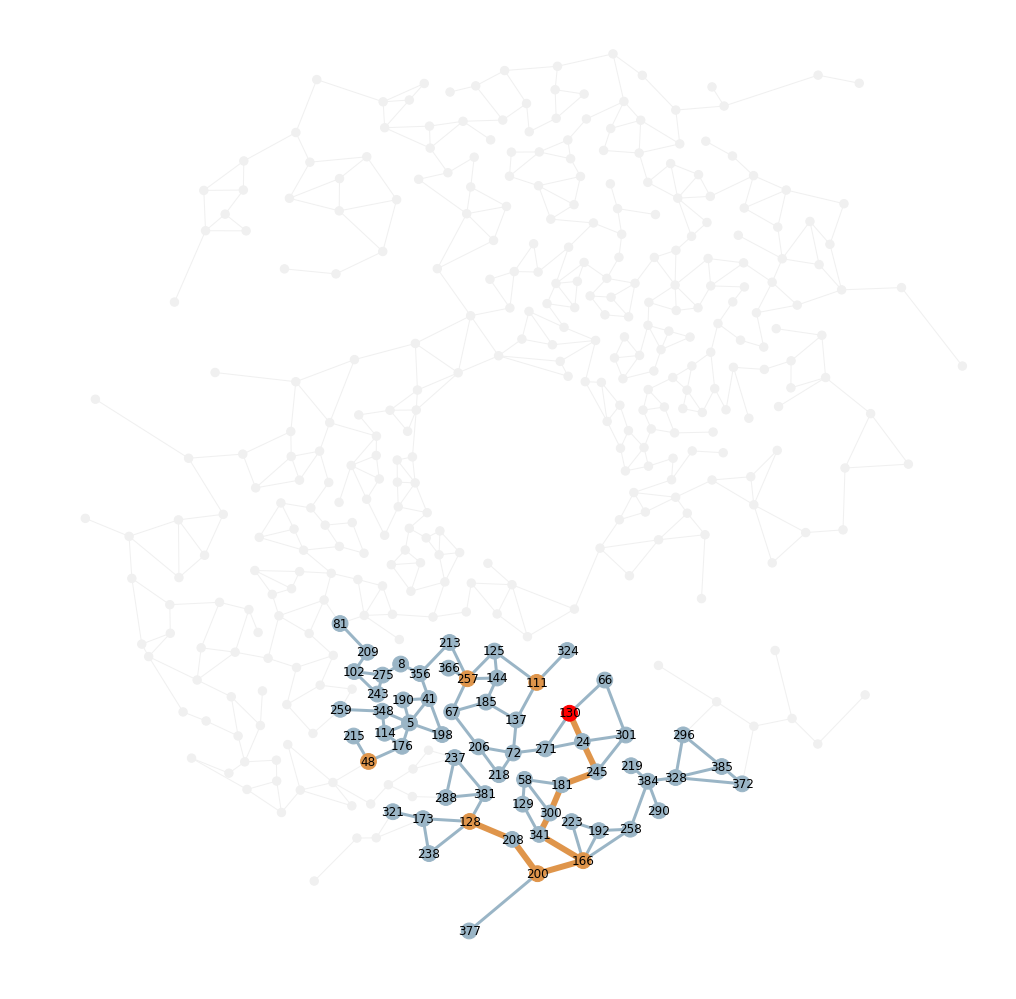

In [64]:
conjunto = set()
for r in mejores_destinos:
    if caminos[r][-1] in mejores_destinos:
        conjunto.update([(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in mejores_destinos and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in rutas_maximales[maximo] or (r[1],r[0]) in rutas_maximales[maximo]) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in rutas_maximales[maximo] or (r[1],r[0]) in rutas_maximales[maximo]) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    300 if r in subg.nodes() and r in rutas_maximales[maximo] 
    else 250 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(mapa_completo, 
        node_size=nodo_tamano, 
        labels=nodo_etiquetas, 
        pos=nodo_posiciones, 
        node_color=nodo_colores, 
        edge_color=arista_colores, 
        width=arista_tamano
)

### Propuesta
Aplica el tsp del ej 5 a esto para dar la ruta, basta con coger todas las combinaciones de los elementos, dar la ruta que los recorre todos, y eliminar la arista mas larga que vaya a el punto origen, esto serviría para calcular de una forma exacta el peso de nuestra nueva ruta, lo que nos permitiria evaluar de forma mas eficiente

<h2><a name="Ubicacion"></a><strong>3. Ubicaciones de la capital</strong></h2>
<p>Ahora que conocemos nuestra galaxia y nos hemos podido abrir paso extendiendo nuestros dominios, llega un punto en el que debemos ubicar aquel sistema que será la <strong>capital</strong> de nuestro <strong>futuro imperio</strong>. El problema se basa en qué sistema o por qué lugar nos vendría bien situar nuestra capital, que esté lo más centrado posible para poder llegar rápidamente a cualquier lugar conquistado o incluso para poder defenderlo fácilemente de cualquier ataque enemigo.</p>
<p>Nos centraremos más en encontrar los sistemas perfectos para asignarles nuestra capital.</p>
<p>Mediante la función <em>mejor_opcion</em> podremos ver los mejores lugares del imperio para colocar una capital.</p>

LÓGICA PARA ABORDAR EL PROBLEMA

Una manera lógica de averiguar cuales son las mejores opciones y cuales las peores es con el centro y la periferia. Al ser los de la periferia los más dificiles de acceder desde dentro de tu imperio, es lógico que sean la peor opción. Justo lo contrario que pasa con el centro


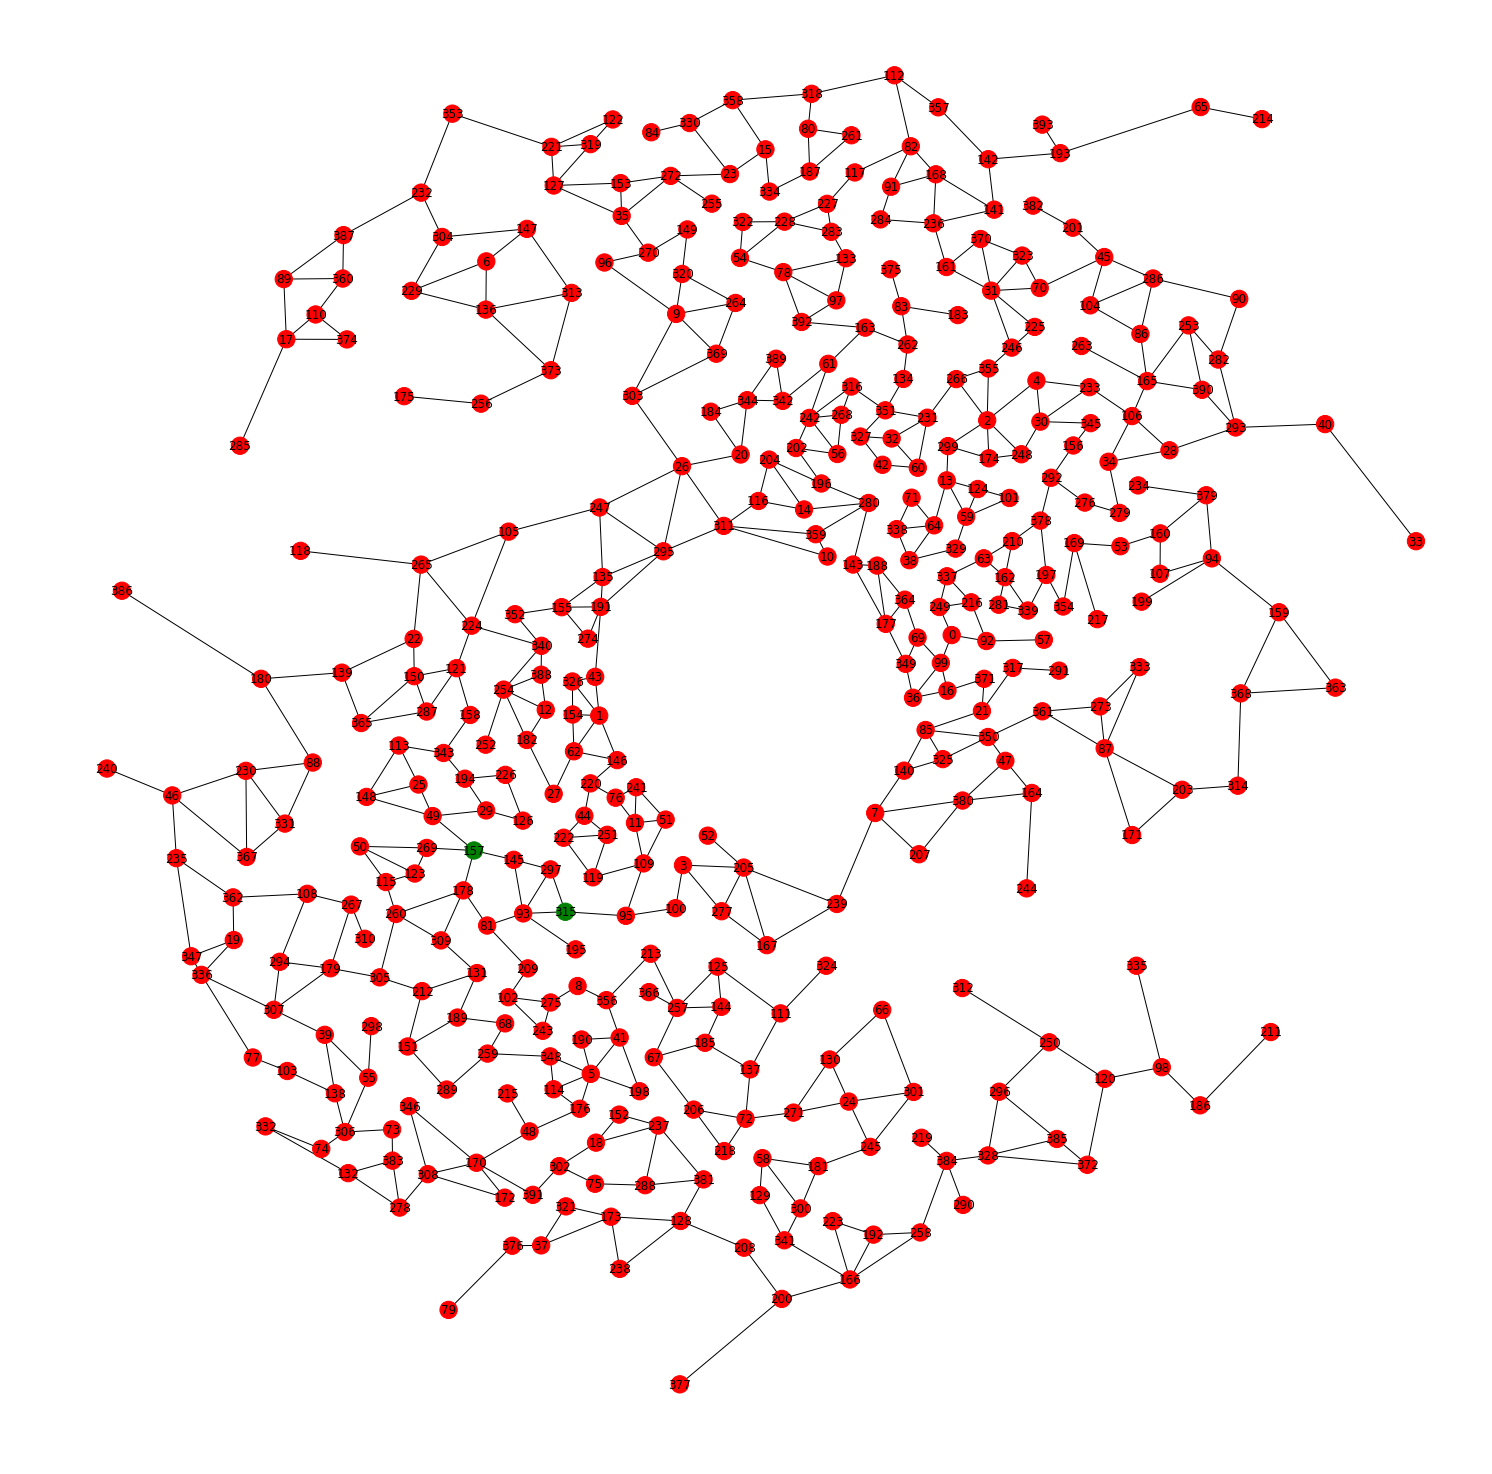

In [65]:
centro = nx.center(mapa_completo)
periferia = nx.periphery(mapa_completo)
colores={node: 'green' if node in centro else 'red' for node in mapa_completo.nodes()}
plt.figure(figsize=(20, 20))
nx.draw(mapa_completo, with_labels=True, node_color=[colores[node] for node in mapa_completo.nodes()], pos = posiciones)
plt.show()

MEJOR SOLUCIÓN

Como es posible que salgan demasiadas posibilidades, para poder decidir la mejor capital, eliminaremos los nodos de la periferia ya que al ser los más dificiles de acceder, son los que más posibilidades tienen de ser conquistados. Así en caso de ser conquistados asegurarnos que la capital sigue estando en un punto facilmente defendible.

In [66]:
def mejor_opcion(g):
    """
    Encuentra iterativamente el centro de un grafo al eliminar vértices periféricos
    hasta que el tamaño del centro sea igual a 1 o se encuentre un conjunto minimo a escoger

    Parameters:
        - g: Grafo de entrada.

    Returns:
        Un conjunto de vértices que constituyen el centro del grafo.
    """
    
    # Se crea una copia del grafo original para evitar modificar el grafo original
    G = g.copy()
    
    # Se ejecuta un bucle mientras el tamaño del centro del grafo no sea igual a 1, es decir, un unico nodo importante
    while not len(nx.center(G))==1:
        # Se verifica si el conjunto de vértices periféricos es vacío o si el radio es igual al diámetro, para saber si hemos acabado
        if not (len(nx.periphery(G)) == 0 or nx.radius(G) == nx.diameter(G)):
            # En caso afirmativo, se itera sobre los vértices periféricos y se elimina cada uno de ellos
            for v in nx.periphery(G):
                G.remove_node(v)
        else:
            # Si no se cumple la condición anterior, se rompe el bucle
            break
    return nx.center(G)

In [67]:
mejor_opcion(mapa_completo)

[315]

<p>No hay mejor lugar para colocar nuestra capital que en un sistema el cuál se puedan <strong>acceder</strong> a todos los lugares de nuestro imperio de una manera más <strong>eficiente</strong> y <strong>rápida</strong>, sin perder nuestro tiempo en defendernos o incluso enviar el apoyo de nuestras tropas a la hora de conquistar.</p>
<p>Para poder localizar el mejor sistema donde instaurar la capital...</p>

<p><strong><strong>EJERCICIO</strong> X:</strong> Utilizando los métodos y atributos disponibles, responder a las siguientes preguntas referentes al grafo G2 definido: ¿Cuales son las posibles capitales de G2?, ¿cual o cuales son las mejores opciones?</p>

[]

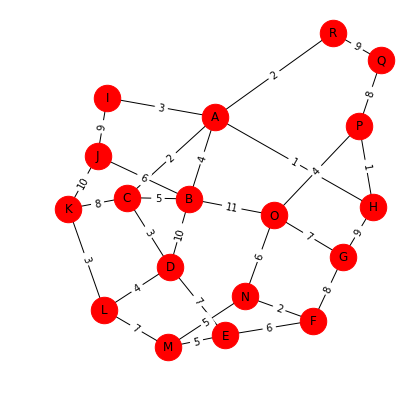

In [68]:
#Este es el grafo que representa el pais
G2 = nx.Graph()

# Agregar nodos al grafo
G2.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R"])

# Agregar aristas con pesos al grafo
G2.add_edge("A", "B", weight=4)
G2.add_edge("A", "C", weight=2)
G2.add_edge("B", "C", weight=5)
G2.add_edge("B", "D", weight=10)
G2.add_edge("C", "D", weight=3)
G2.add_edge("D", "E", weight=7)
G2.add_edge("E", "F", weight=6)
G2.add_edge("F", "G", weight=8)
G2.add_edge("G", "H", weight=9)
G2.add_edge("H", "A", weight=1)
G2.add_edge("A", "I", weight=3)
G2.add_edge("B", "J", weight=6)
G2.add_edge("C", "K", weight=8)
G2.add_edge("D", "L", weight=4)
G2.add_edge("E", "M", weight=5)
G2.add_edge("F", "N", weight=2)
G2.add_edge("G", "O", weight=7)
G2.add_edge("H", "P", weight=1)
G2.add_edge("I", "J", weight=9)
G2.add_edge("J", "K", weight=10)
G2.add_edge("K", "L", weight=3)
G2.add_edge("L", "M", weight=7)
G2.add_edge("M", "N", weight=5)
G2.add_edge("N", "O", weight=6)
G2.add_edge("O", "P", weight=4)
G2.add_edge("P", "Q", weight=8)
G2.add_edge("Q", "R", weight=9)
G2.add_edge("R", "A", weight=2)
G2.add_edge("A", "I", weight=3)
G2.add_edge("B", "J", weight=6)
G2.add_edge("B", "O", weight=11)

plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G2)  # Layout para posicionar los nodos
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700)
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.plot()

SOLUCIÓN

[]

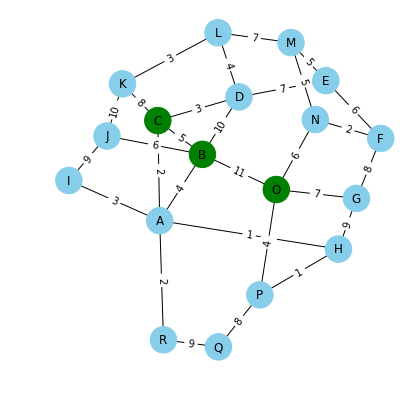

In [69]:
centro = nx.center(G2)

plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G2)  # Layout para posicionar los nodos
nodo_colores = ["green" if nodo in centro else "skyblue" for nodo in G2.nodes]
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700, node_color=nodo_colores)
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.plot()

In [70]:
mejor_opcion(G2)

['B']

<h2><a name="Comercio"></a><strong>4. Estudio del comercio</strong>

A la hora de hacer un estudio del comercio, sacamos un arbol donde la raíz sería nuestra capital.

In [71]:
# Crear un grafo
G = Graph()

# Agregar vértices
G.add_vertices(['A', 'B', 'C', 'D', 'E', 'F', 'G'])

# Asignar pesos a los vértices
G.set_vertices({'A': {'weight': 3}, 'B': {'weight': 5}, 'C': {'weight': 2}, 'D': {'weight': 5}, 'E': {'weight': 5}
               , 'F': {'weight': 5}, 'G': {'weight': 5}})

# Agregar aristas
aristas=[('A','B',36),('A','C',12),('B','D',34),('C','E',45),('E','F',48),('E','G',18)]
G.add_edges(aristas)

Cada sistema tiene un valor de comercio que podemos verlo de la siguiente manera.

In [72]:
# Obtener el peso de un vértice específico
peso_A = G.get_vertex('A')['weight']
peso_B = G.get_vertex('B')['weight']
peso_C = G.get_vertex('C')['weight']

# Imprimir resultados
print("Peso del vértice A:", peso_A)
print("Peso del vértice B:", peso_B)
print("Peso del vértice C:", peso_C)

Peso del vértice A: 3
Peso del vértice B: 5
Peso del vértice C: 2


También podemos ver la distancia entre sistema y sistema de la siguiente manera.

In [73]:
G.edges()

[('A', 'B', 36), ('A', 'C', 12), ('B', 'D', 34), ('C', 'E', 45), ('E', 'F', 48), ('E', 'G', 18)]

La función importancia nos da un diccionario donde las claves son cada sistema y los valores es la impotancia de cada uno de ellos.

In [74]:
def importancia(capital, g, nodo=None):
    """
    Calcula la importancia de cada vértice en un arbol.

    Parameters:
        - capital: El vértice desde el cual se calcula la importancia.
        - g: El grafo ponderado.
        - nodo: Opcional, si se especifica, devuelve la importancia solo para ese nodo.

    Returns:
        Un diccionario donde las claves son los vértices y los valores son las medidas de importancia.
        Si se especifica el parámetro 'nodo', devuelve la importancia solo para ese nodo.
    """
    # Inicializar el diccionario de importancia
    importante={}
    
    # Verificar si el grafo es un árbol
    if not g.is_tree():
        raise ValueError("El grafo no es un arbol. Lo has copiado mal listillo. :)")
    elif not es_ponderado_por_vertices(g):
        raise ValueError("El grafo no está ponderado por vertices. Lo has copiado mal listillo. :)")
    else:
        
        # Definir una función interna para calcular la importancia recursivamente
        def calcular_importancia(v):
            """
            Calcula la importancia de cada vértice en un árbol.

            Parameters:
                - v: El vértice actual para el cual se calcula la importancia.

            Returns:
                Un valor que representa la importancia del vértice actual en el árbol.
            """
            # Calcular el peso y la distancia desde la capital hasta el vértice actual
            peso = g.get_vertex(v)['weight']
            distancia = g.shortest_path_length(capital, v, by_weight=True)
            
            # Calcular la importancia para el vértice actual
            valor = peso / distancia
            
            # Sumar la importancia de los hijos y los hijos de los hijos
            suma_hijos = sum(calcular_importancia(hijo) for hijo in children(g,v))
            return valor + suma_hijos
        
        # Calcular la importancia final para cada vértice en el grafo
        for v in g.vertices():
            if not v == capital:
                valor = calcular_importancia(v)
                importante[v] = float(valor)
        
        if nodo==None:
            return importante
        else:
            return importante[nodo]

def children(t,c=None):
    """
    Devuelve una lista que contiene los hijos del nodo dado perteneciente al árbol.

    Parameters:
        - t: El árbol.
        - c: El nodo dado.

    Returns:
        Un diccionario donde las claves son los vértices y los valores la lista de hijos del nodo.
    """
    dic = {}
    lista_visitados = []

    for v in t.vertices():
        lista_hijos = []
        lista_visitados.append(v)
        for vecino in t.neighbors(v):
            if vecino not in lista_visitados:
                lista_hijos.append(vecino)
        dic[v] = lista_hijos
        
    if c==None:
        return dic
    else:
        return dic[c]

def es_ponderado_por_vertices(grafo):
    """
    Verifica si un grafo es ponderado por vertices.

    Parameters:
        - grafo: El grafo a verificar.

    Returns:
        True si todos los vertices tienen un peso, False de lo contrario.
    """
    for v in grafo.vertices():
        datos = grafo.get_vertex(v)
        if not isinstance(datos, dict) or 'weight' not in datos:
            return False
    return True

La funcion se utiliza de la siguiente manera, se coloca la raiz primero y luego el grafo, y en el caso de que quieras conoces la importancia de solo 1 de los nodos, se ponde el nodo que quieras conoces. La raiz se excluye porque siempre será la más importante

In [75]:
dic =importancia('A',G)
print('Las importancias de cada nodo del arbol:',dic)

dic = importancia('A',G, 'D')
print('La importancias del nodo D:',dic)

Las importancias de cada nodo del arbol: {'B': 0.21031746031746032, 'C': 0.368671679197995, 'D': 0.07142857142857142, 'E': 0.20200501253132833, 'F': 0.047619047619047616, 'G': 0.06666666666666667}
La importancias del nodo D: 0.07142857142857142


<p><strong><strong>EJERCICIO</strong> X:</strong> Utilizando los métodos y atributos disponibles, responder a las siguientes preguntas referentes al grafo G1 definido: ¿Es el grafo G1 un arbol?, ¿que valores de comercio en cada sistema de G1?, ¿Cual es el sistema más importante después de la capital?</p>

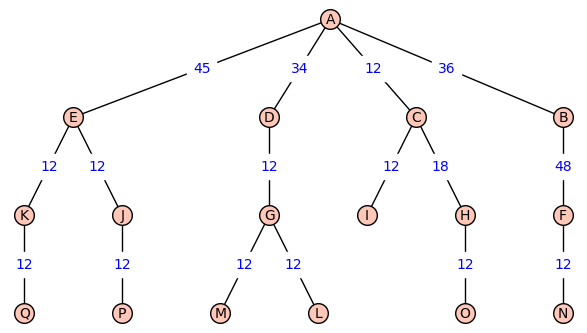

In [76]:
G1 = Graph()
G1.add_vertices(['A', 'B', 'C', 'D', 'E', 'F', 'G','H','I','J','K','L','M','N','O','P','Q'])
G1.set_vertices({'A': {'weight': 5}, 'B': {'weight': 6.23445}, 'C': {'weight': 2.12355}, 'D': {'weight': 6}, 'E': {'weight': 0.2}
               , 'F': {'weight': 9.8123}, 'G': {'weight': 4.12}, 'H': {'weight': 4.21}, 'I': {'weight': 7.2}, 'J': {'weight': 5}
                , 'K': {'weight': 4.53}, 'L': {'weight': 3.234}, 'M': {'weight': 8}, 'N': {'weight': 5.65}, 'O': {'weight': 7.2}
               , 'P': {'weight': 5.2345}, 'Q': {'weight': 8.234663}})
aristas=[('A','B',36),('A','C',12),('A','D',34),('A','E',45),('B','F',48),('C','H',18),('C','I',12),('D','G',12),('E','J',12)
        ,('E','K',12),('F','N',12),('H','O',12),('G','L',12),('G','M',12),('J','P',12),('K','Q',12)]
G1.add_edges(aristas)
G1.plot(layout='tree', edge_labels=True)

SOLUCIÓN

In [77]:
G1.is_tree()

True

In [78]:
for v in G1.vertices():
    peso = G1.get_vertex(v)['weight']
    print("Valor de comercio del vértice ",v,":", peso)

Valor de comercio del vértice  A : 5
Valor de comercio del vértice  B : 6.23445000000000
Valor de comercio del vértice  C : 2.12355000000000
Valor de comercio del vértice  D : 6
Valor de comercio del vértice  E : 0.200000000000000
Valor de comercio del vértice  F : 9.81230000000000
Valor de comercio del vértice  G : 4.12000000000000
Valor de comercio del vértice  H : 4.21000000000000
Valor de comercio del vértice  I : 7.20000000000000
Valor de comercio del vértice  J : 5
Valor de comercio del vértice  K : 4.53000000000000
Valor de comercio del vértice  L : 3.23400000000000
Valor de comercio del vértice  M : 8
Valor de comercio del vértice  N : 5.65000000000000
Valor de comercio del vértice  O : 7.20000000000000
Valor de comercio del vértice  P : 5.23450000000000
Valor de comercio del vértice  Q : 8.23466300000000


In [79]:
dic =importancia('A',G1)
valor_max = max(dic.values())
importantes = [clave for clave, valor in dic.items() if valor == valor_max]
print(importantes)

['C']


<h2><a name="Conquista"></a><strong>5. Conquista eficiente</strong></h2>

Ahora que nuestra política comercial interna está asegurada llega el momento de expandir nuestro poder más allá de nuestras fronteras, hemos elegido un rival débil, al que conquistaremos rápidamente, pero tememos al alejar nuestra flota de nuestro hogar, por ello necesitamos saber cual es la forma más rapida de deshacernos de nuestro enemigo.
Sabemos que el imperio xeno solo capitulará si todos sus paises son conquistados, por ello, ¿cual es la ruta más rapida para tomarlos todos?

In [80]:
#Este es el grafo que representa el pais enemigo
G = nx.Graph()

# Agregar nodos al grafo
G.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R"])

# Agregar aristas con pesos al grafo
G.add_edge("A", "B", weight=4)
G.add_edge("A", "C", weight=2)
G.add_edge("B", "C", weight=5)
G.add_edge("B", "D", weight=10)
G.add_edge("C", "D", weight=3)
G.add_edge("D", "E", weight=7)
G.add_edge("E", "F", weight=6)
G.add_edge("F", "G", weight=8)
G.add_edge("G", "H", weight=9)
G.add_edge("H", "A", weight=1)
G.add_edge("A", "I", weight=3)
G.add_edge("B", "J", weight=6)
G.add_edge("C", "K", weight=8)
G.add_edge("D", "L", weight=4)
G.add_edge("E", "M", weight=5)
G.add_edge("F", "N", weight=2)
G.add_edge("G", "O", weight=7)
G.add_edge("H", "P", weight=1)
G.add_edge("I", "J", weight=9)
G.add_edge("J", "K", weight=10)
G.add_edge("K", "L", weight=3)
G.add_edge("L", "M", weight=7)
G.add_edge("M", "N", weight=5)
G.add_edge("N", "O", weight=6)
G.add_edge("O", "P", weight=4)
G.add_edge("P", "Q", weight=8)
G.add_edge("Q", "R", weight=9)
G.add_edge("R", "A", weight=2)
G.add_edge("A", "I", weight=3)
G.add_edge("B", "J", weight=6)

In [81]:
#Estos son sus sistemas con planetas
nodos_terminales = {"C", "D", "E", "N", "R", "P", "O", "K"}

Este problema guarda cierto parecido con otro más conocido, [el problema del viajante](https://es.wikipedia.org/wiki/Problema_del_viajante), sin embargo no tenemos que recorrer todos los puntos, lo que hace que tengamos que adaptar la solucion.
<p>Podemos extraer de nuestro grafo original un subgrafo en el que los nodos son los nodos con planeta, y las aristas entre ellos serán el camino más corto de un nodo a otro(Dijkstra). En el caso de que el camino mas corto de un nodo con planeta A a un nodo con planeta B cruce un nodo con planeta C, no habrá arista de A-B, sino de A-C-B

Este es nuestro grafo al comenzar

[]

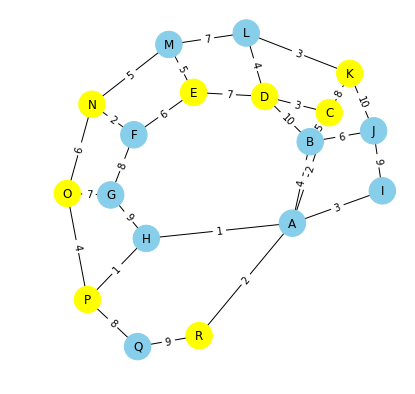

In [82]:
plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G)  # Layout para posicionar los nodos
nodo_colores = ["yellow" if nodo in nodos_terminales else "skyblue" for nodo in G.nodes]
nx.draw(G, pos=nodo_pos, with_labels=True, node_size=700, node_color=nodo_colores)
nx.draw_networkx_edge_labels(G, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.plot()

In [83]:
def subgrafo(grafo: nx.Graph, sistplan: set):    
    aristas = []
    dictarista_recorrido = dict()
    for i in sistplan:
        distancias, caminos  = nx.single_source_dijkstra(grafo, source=i)
        listarecorridos = []
        for r in caminos:
            origen = caminos[r][0] 
            destino = r
            distancia = distancias[r]
            if(origen!=destino and destino in sistplan):
                a = True           
                for destinatario in sistplan:                    
                    if destinatario!=origen and destinatario!=destino and destinatario in caminos[r]:
                        a = False                
                if(a):                     
                    aristas.append((origen, destino, distancia))
                    listarecorridos.append((origen, destino, caminos[r]))
        dictarista_recorrido[origen] = [tuple(k for k in r[2]) for r in listarecorridos]
    grafores = nx.Graph()
    grafores.add_weighted_edges_from(aristas)
    return grafores, dictarista_recorrido

In [84]:
G2, dict_recorridos = subgrafo(G, nodos_terminales)
print(nx.to_dict_of_lists(G2))

{'N': ['O', 'E', 'K'], 'O': ['N', 'P'], 'E': ['N', 'D'], 'K': ['N', 'C', 'D'], 'R': ['C', 'P'], 'C': ['R', 'D', 'K', 'P'], 'P': ['R', 'C', 'O'], 'D': ['E', 'C', 'K']}


Visualizamos el grafo ahora que lo hemos reducido, como podras observar, solo hemos mantenido los nodos con planeta, y las aristas entre ellos son los caminos minimos

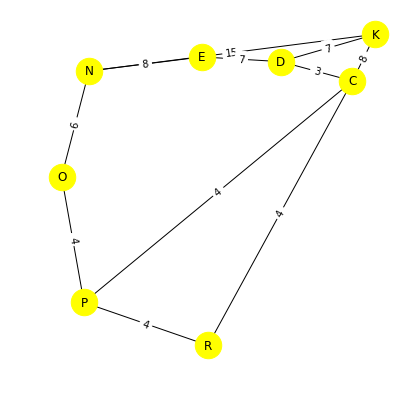

In [85]:
plt.figure(figsize=(5, 5))
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700, node_color="yellow")
arista_etiquetas = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=arista_etiquetas)
plt.show()

Podriamos aplicar el algoritmo tsp sobre este grafo, sin embargo, tenemos que hacer otro remapeo para obtener la ruta más eficiente, pues el problema del viajante establece una limitacion, que solo se puede pasar por cada nodo una sola vez.<p>
La forma de solucionar esto es volviendo a crear las aristas, de nuevo con los caminos minimos

In [86]:
def remapea(grafo: nx.Graph):
    aristas = []
    dictarista_recorrido = dict()
    for i in grafo.nodes():
        #Distancia desde todos los puntos hasta nuestro punto i
        distancias, caminos  = nx.single_source_dijkstra(grafo, source=i)
        listarecorridos = []
        for r in caminos:
            origen = caminos[r][0] 
            destino = r
            distancia = distancias[r]
            if(origen!=destino):
                aristas.append((origen, destino, distancia))
                listarecorridos.append((origen, destino, caminos[r]))
        dictarista_recorrido[origen] = [tuple(k for k in r[2]) for r in listarecorridos]
    grafores = nx.Graph()
    grafores.add_weighted_edges_from(aristas)
    return grafores, dictarista_recorrido

In [87]:
G3, dict_recorridos2 = remapea(G2)
print(nx.to_dict_of_lists(G3))

{'N': ['O', 'E', 'K', 'P', 'D', 'R', 'C'], 'O': ['N', 'P', 'R', 'C', 'E', 'K', 'D'], 'E': ['N', 'O', 'D', 'C', 'K', 'R', 'P'], 'K': ['N', 'O', 'E', 'C', 'D', 'R', 'P'], 'P': ['N', 'O', 'E', 'K', 'R', 'C', 'D'], 'D': ['N', 'O', 'E', 'K', 'R', 'C', 'P'], 'R': ['N', 'O', 'E', 'K', 'C', 'P', 'D'], 'C': ['N', 'O', 'E', 'K', 'R', 'D', 'P']}


Lo visualizamos

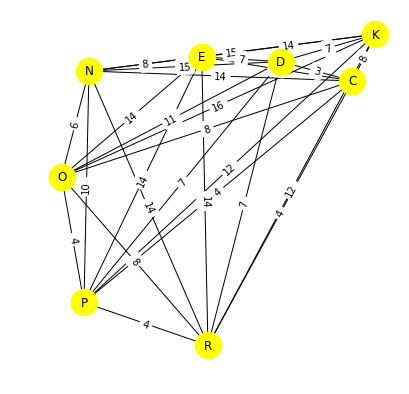

In [88]:
plt.figure(figsize=(5, 5))
nx.draw(G3, pos=nodo_pos, with_labels=True, node_size=700, node_color="yellow")
arista_etiquetas = nx.get_edge_attributes(G3, 'weight')
nx.draw_networkx_edge_labels(G3, pos=nodo_pos, edge_labels=arista_etiquetas)
plt.show()

Ahora sí podemos aplicar el algoritmo tsp, se ha de tener en cuenta que como la complejidad de tsp es n!, usaremos un metodo voraz para hallar la solucion, este algoritmo no es mio, sino extraido de la documentacion de networkx

In [89]:
def swap_two_nodes(soln, seed):
    a, b = random.sample(range(1, len(soln) - 1), k=2)
    soln[a], soln[b] = soln[b], soln[a]
    return soln

def pairwise(iterable, cyclic=False):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = tee(iterable)
    first = next(b, None)
    if cyclic is True:
        return zip(a, chain(b, (first,)))
    return zip(a, b)

def greedy_tsp(G: nx.Graph, weight="weight", source=None):
    # Check that G is a complete graph
    N = len(G) - 1
    # This check ignores selfloops which is what we want here.
    if any(len(nbrdict) - (n in nbrdict) != N for n, nbrdict in G.adj.items()):
        raise nx.NetworkXError("G must be a complete graph.")

    if source is None:
        source = nx.utils.arbitrary_element(G)

    if G.number_of_nodes() == 2:
        neighbor = next(G.neighbors(source))
        return [source, neighbor, source]

    nodeset = set(G)
    nodeset.remove(source)
    cycle = [source]
    next_node = source
    while nodeset:
        nbrdict = G[next_node]
        next_node = min(nodeset, key=lambda n: nbrdict[n].get(weight, 1))
        cycle.append(next_node)
        nodeset.remove(next_node)
    cycle.append(cycle[0])
    return cycle

def tsp(
    G,
    init_cycle="greedy",
    weight="weight",
    source=None,
    temp=500,
    move="1-1",
    max_iterations=10,
    N_inner=1000,
    alpha=0.01,
    seed=None,
):

    if move == "1-1":
        move = swap_two_nodes
    elif move == "1-0":
        move = move_one_node
    if init_cycle == "greedy":
        # Construct an initial solution using a greedy algorithm.
        cycle = greedy_tsp(G, weight=weight, source=source)
        if G.number_of_nodes() == 2:
            return cycle

    else:
        cycle = list(init_cycle)
        if source is None:
            source = cycle[0]
        elif source != cycle[0]:
            raise nx.NetworkXError("source must be first node in init_cycle")
        if cycle[0] != cycle[-1]:
            raise nx.NetworkXError("init_cycle must be a cycle. (return to start)")

        if len(cycle) - 1 != len(G) or len(set(G.nbunch_iter(cycle))) != len(G):
            raise nx.NetworkXError("init_cycle should be a cycle over all nodes in G.")

        # Check that G is a complete graph
        N = len(G) - 1
        # This check ignores selfloops which is what we want here.
        if any(len(nbrdict) - (n in nbrdict) != N for n, nbrdict in G.adj.items()):
            raise nx.NetworkXError("G must be a complete graph.")

        if G.number_of_nodes() == 2:
            neighbor = next(G.neighbors(source))
            return [source, neighbor, source]

    # Find the cost of initial solution
    cost = sum(G[u][v].get(weight, 1) for u, v in pairwise(cycle))

    count = 0
    best_cycle = cycle.copy()
    best_cost = cost
    while count <= max_iterations and temp > 0:
        count += 1
        for i in range(N_inner):
            adj_sol = move(cycle, seed)
            adj_cost = sum(G[u][v].get(weight, 1) for u, v in pairwise(adj_sol))
            delta = adj_cost - cost
            if delta <= 0:
                # Set current solution the adjacent solution.
                cycle = adj_sol
                cost = adj_cost

                if cost < best_cost:
                    count = 0
                    best_cycle = cycle.copy()
                    best_cost = cost
            else:
                # Accept even a worse solution with probability p.
                p = math.exp(-delta / temp)
                if p >= random.random():
                    cycle = adj_sol
                    cost = adj_cost
        temp -= temp * alpha

    return best_cycle

In [90]:
recorrido = tsp(G3)
print(recorrido)

['N', 'E', 'D', 'K', 'C', 'R', 'P', 'O', 'N']


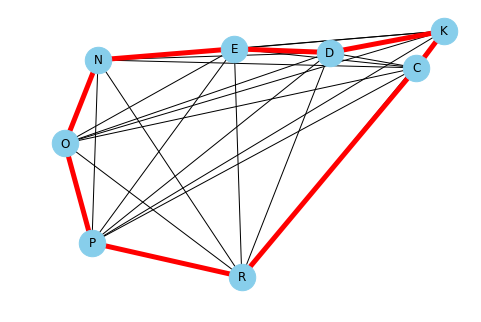

In [91]:
#Camino sobre el grafo reducido
arista_color = {edge: {'color': 'red'} for _, edge in enumerate(zip(recorrido, recorrido[1:]))}
nx.draw(G3, pos=nodo_pos, with_labels=True, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G3, pos=nodo_pos, edgelist=arista_color.keys(), edge_color='red', width=5)
plt.show()

Ahora reasociamos las aristas del subgrafo a los caminos a los que corresponden

In [92]:
def asocia(lista: list,dicc: dict):
    recorrido = []
    for i in range(len(lista)-1):
        for j in range(len(dicc.get(lista[i]))):
            if lista[i+1]==dicc.get(lista[i])[j][-1]:
                recorrido.extend(dicc.get(lista[i])[j])
    for i in range(len(recorrido)-1, 0, -1):
        if recorrido[i] == recorrido[i-1]:
            del recorrido[i]
    return recorrido

nuestra ruta será la siguiente

In [93]:
resultado1de2 = asocia(recorrido, dict_recorridos2)
resultado2de2 = asocia(resultado1de2, dict_recorridos)
print(resultado2de2)
peso_total = sum([G.edges()[(resultado2de2[i], resultado2de2[i + 1])]["weight"] for i in range(0, len(resultado2de2)-1)])
print("El peso total de nuestra ruta es de: ", peso_total)

['N', 'F', 'E', 'D', 'L', 'K', 'C', 'A', 'R', 'A', 'H', 'P', 'O', 'N']
El peso total de nuestra ruta es de:  48


Representamos la solucion

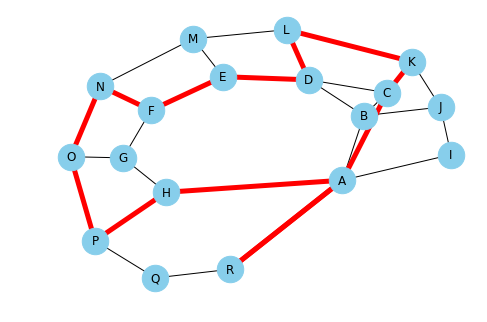

In [94]:
arista_color = {edge: {'color': 'red'} for _, edge in enumerate(zip(resultado2de2, resultado2de2[1:]))}
nx.draw(G, pos=nodo_pos, with_labels=True, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos=nodo_pos, edgelist=arista_color.keys(), edge_color='red', width=5)
plt.show()

<h2><a name="Defensa"></a><strong>6. Defensa del imperio</strong></h2>

Raddichi: numero de triangulos formado por esa arista+1(para evitar caso 0)/min(gradovertice i -1, gradoverticej -1)

In [95]:
def numero_de_triangulos(graph, i, j):
    """
    Calcula el número de triángulos formados por los vértices i y j mediante sus vecinos comunes en un grafo.

    Parameters:
        - graph: Grafo de entrada.
        - i: Primer vértice.
        - j: Segundo vértice.

    Returns:
        Número de triángulos formados por los vértices i, j y sus vecinos comunes.
    """
    # Encontrar vecinos comunes de i y j
    vecinos_comunes = set(graph.neighbors(i)) & set(graph.neighbors(j))

    # Contar triángulos formados por i, j y los vecinos comunes
    num_triangulos = 0
    for vecino in vecinos_comunes:
        if graph.has_edge(i, vecino) and graph.has_edge(j, vecino):
            num_triangulos += 1

    return num_triangulos

def radicchi(g, show=False, grafo_para_plotear=None):
    """
    Realiza una modificación en un grafo utilizando el algoritmo Radicchi para la detección de comunidades.
    Elimina aristas con coeficiente mínimo calculado según la fórmula de Radicchi.

    Parameters:
        - g: Grafo de entrada.

    Returns:
        Un nuevo grafo con las aristas eliminadas y representación gráfica de las comunidades.
    """
    
    # Copiar el grafo de entrada para no modificar el original
    G = g.copy()
    # Crear un diccionario para almacenar los coeficientes de las aristas
    dic = {}
    
    # Iterar sobre todas las aristas del grafo
    for arista in list(G.edges()):
        i = arista[0]
        j = arista[1]
        gradoi = G.degree(i)
        gradoj = G.degree(j)
        
        # Verificar que los grados no sean iguales a 1 para evitar divisiones por cero
        if not (gradoi==1 or gradoj==1):
            # Calcular el número de triángulos formados por i, j y sus vecinos comunes
            triangulos = numero_de_triangulos(G, i, j)
            # Calcular el coeficiente según la fórmula de Radicchi
            coeficiente = (triangulos+1)/min(gradoi-1, gradoj-1)
            dic[arista] = coeficiente
            
    # Encontrar el valor mínimo entre los coeficientes
    valor_minimo = min(dic.values())
    # Crear una lista de aristas con el coeficiente mínimo
    aristas = [clave for clave, valor in dic.items() if valor == valor_minimo]
    
    # Eliminar las aristas con el coeficiente mínimo
    for arista in aristas:
        G.remove_edge(arista[0],arista[1])
    
    if show:
        comunidades = list(nx.connected_components(G))
        if grafo_para_plotear==None:
            plotear_grafo_con_comunidades(g, comunidades)
        else:
            plotear_grafo_con_comunidades(grafo_para_plotear, comunidades)
    
    return G

def plotear_grafo_con_comunidades(grafo, comunidades):
    """
    Visualiza un grafo con nodos coloreados según las comunidades.

    Parameters:
        - grafo: Grafo a visualizar.
        - comunidades: Lista de conjuntos, cada uno representando una comunidad.

    Returns:
        None
    """
    
    # Lista de colores para las comunidades
    colores = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lime', 'indigo',
           'teal', 'maroon', 'navy', 'sienna', 'orchid', 'darkgreen', 'saddlebrown', 'firebrick', 'slategray', 'darkcyan',
           'darkkhaki', 'darkmagenta', 'salmon', 'gold', 'lightblue', 'darkorchid', 'darkred', 'mediumseagreen', 'mediumvioletred',
           'seagreen', 'mediumturquoise', 'orangered', 'royalblue', 'tomato', 'palegreen', 'midnightblue', 'hotpink', 'peru',
           'deepskyblue', 'sienna', 'forestgreen', 'steelblue', 'dodgerblue', 'chocolate', 'goldenrod', 'greenyellow', 'lightcoral',
           'cornflowerblue', 'darkolivegreen', 'darkslategray', 'mediumaquamarine', 'darkorange', 'mediumspringgreen', 'dimgrey',
           'darkseagreen', 'dodgerblue', 'darkviolet', 'darkslateblue', 'crimson', 'orangered', 'darkgoldenrod', 'darkcyan',
           'darkkhaki', 'darkmagenta', 'darkred', 'darkgreen', 'darkblue', 'darkorange', 'darkolivegreen', 'darkorchid', 'darkseagreen',
           'darkslateblue', 'darkslategray', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dodgerblue', 'firebrick',
           'forestgreen', 'fuchsia', 'gold', 'goldenrod', 'green', 'greenyellow', 'grey', 'hotpink', 'indianred', 'indigo', 'khaki',
           'lawngreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
           'lightslategray', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue',
           'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred',
           'midnightblue', 'navajowhite', 'navy', 'olive', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
           'palevioletred', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon',
           'sandybrown', 'seagreen', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'tan',
           'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
    
    posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
    plt.figure(figsize=(20, 20))
    
    for i, comunidad in enumerate(comunidades):
        nx.draw_networkx_nodes(grafo, posiciones, nodelist=comunidad, node_color=colores[i % len(colores)], label=f'Comunidad {i + 1}')
    
    nx.draw_networkx_edges(grafo, posiciones, ax=None)
    nx.draw_networkx_labels(grafo, posiciones)
    
    plt.legend()
    plt.show()


como ver resiltados

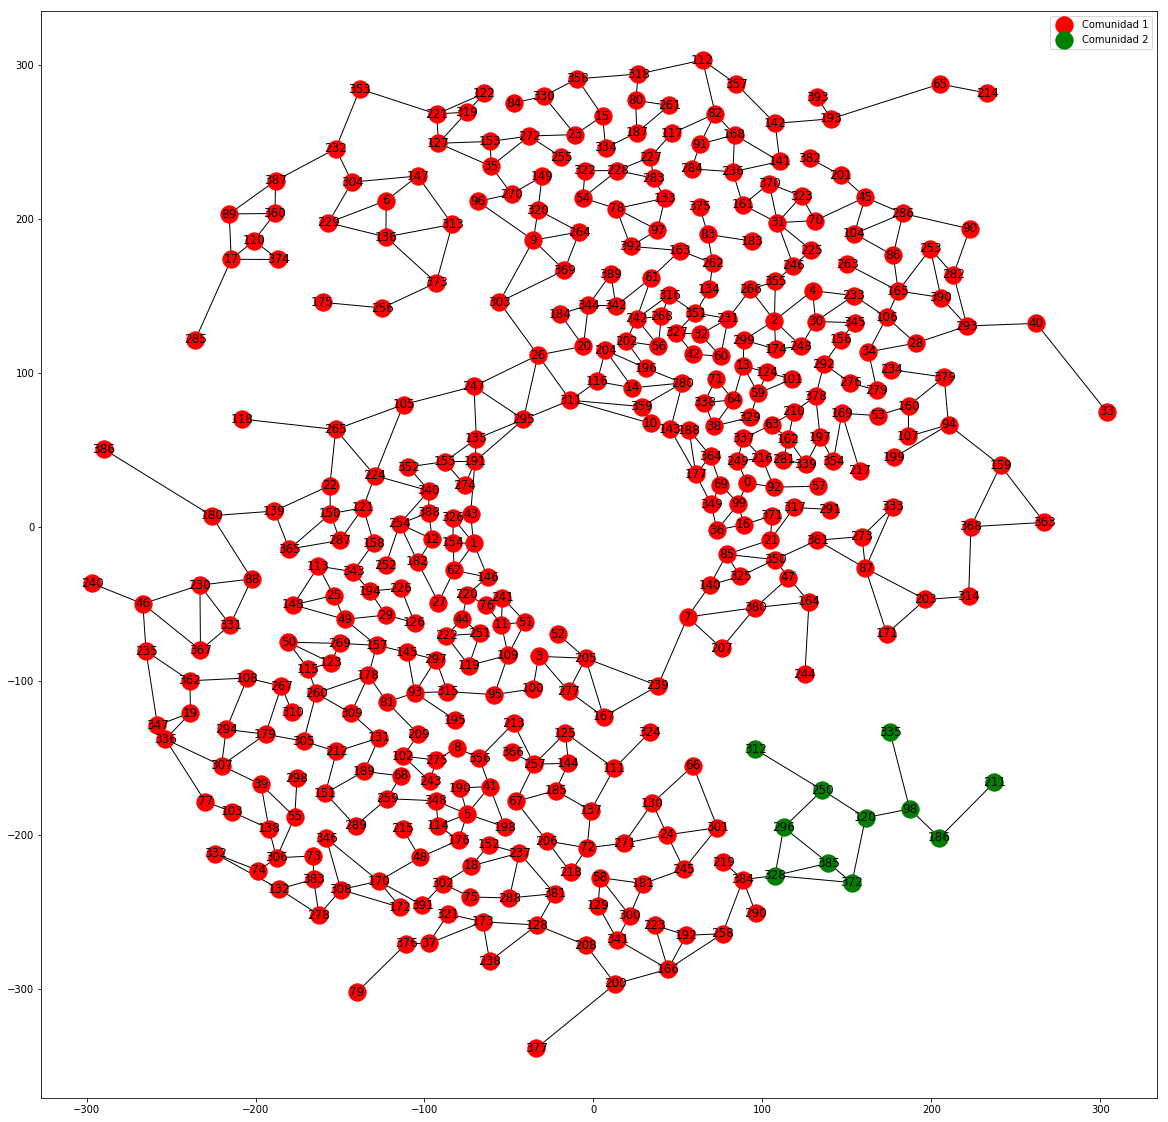

In [96]:
G = radicchi(mapa_completo)
comunidades = list(nx.connected_components(G))
plotear_grafo_con_comunidades(mapa_completo, comunidades)